Toxic Comment Classifier


In [33]:
# رفع ملف kaggle.json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmed744","key":"cf3ca2190cbf42aa336b498c7644cb1f"}'}

In [34]:
# إعداد وتحميل البيانات
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# تحميل الداتا
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

# فك الضغط
!unzip jigsaw-toxic-comment-classification-challenge.zip


jigsaw-toxic-comment-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  jigsaw-toxic-comment-classification-challenge.zip
replace sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [36]:
import zipfile

# فك الضغط لملف train.csv.zip
with zipfile.ZipFile("train.csv.zip", 'r') as zip_ref:
    zip_ref.extractall()
import os

print("train.csv موجود؟", os.path.exists("train.csv"))


train.csv موجود؟ True


In [37]:
import pandas as pd

# قراءة الملف
df = pd.read_csv("train.csv")

# عرض أول 5 صفوف
df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [38]:
import pandas as pd

# قراءة ملف البيانات
df = pd.read_csv("train.csv")

# عرض أول 5 صفوف
print(df.head())

# عرض أسماء الأعمدة
print("\nأسماء الأعمدة:\n", df.columns.tolist())

# عدد الصفوف
print(f"\nعدد التعليقات: {len(df)}")

# عرض توزيع الفئات
print("\nتوزيع الفئات:")
print(df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum())

# عدد التعليقات غير المسيئة
df['non_toxic'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) == 0)
print(f"\nعدد التعليقات غير المسيئة: {df['non_toxic'].sum()}")


                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  

أسماء الأعمدة:
 ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

عدد التعليقات: 159571

توزيع الفئات:
toxic         

In [39]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
!pip install emoji


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
import emoji
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # 1. تحويل الإيموجي لكلمات
    text = emoji.demojize(text)

    # 2. تحويل للحروف الصغيرة
    text = text.lower()

    # 3. إزالة الروابط
    text = re.sub(r"http\S+", "", text)

    # 4. إزالة الرموز الغريبة (مع الإبقاء على الإيموجي النصية مثل ":smile:")
    text = re.sub(r"[^a-z:_\s]", "", text)

    # 5. إزالة الأرقام
    text = re.sub(r"\d+", "", text)

    # 6. إزالة الكلمات الشائعة
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # 7. إعادة النص
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# إعادة إنشاء العمود cleaned_text
df['cleaned_text'] = df['comment_text'].apply(clean_text)

# عرض مثال قبل وبعد
print("قبل التنظيف:\n", df['comment_text'].iloc[0])
print("\nبعد التنظيف:\n", df['cleaned_text'].iloc[0])


قبل التنظيف:
 Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

بعد التنظيف:
 explanation edits made username hardcore metallica fan reverted werent vandalisms closure gas voted new york dolls fac please dont remove template talk page since im retired


In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [43]:
# استخدام العمود cleaned_text كـ input، وlabel كـ output
# إنشاء عمود label: 1 لو التعليق فيه أي نوع إساءة، 0 لو نظيف
df['label'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0).astype(int)
X = df['cleaned_text']
y = df['label']

# تقسيم البيانات إلى تدريب واختبار (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
# إنشاء محول TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))  # unigram + bigram

# تدريب وتحويل بيانات التدريب
X_train_tfidf = tfidf.fit_transform(X_train)

# تحويل بيانات الاختبار
X_test_tfidf = tfidf.transform(X_test)


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# إنشاء وتدريب النموذج
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# التوقع
y_pred = model.predict(X_test_tfidf)

# تقرير الأداء
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98     28671
           1       0.92      0.62      0.74      3244

    accuracy                           0.96     31915
   macro avg       0.94      0.81      0.86     31915
weighted avg       0.95      0.96      0.95     31915



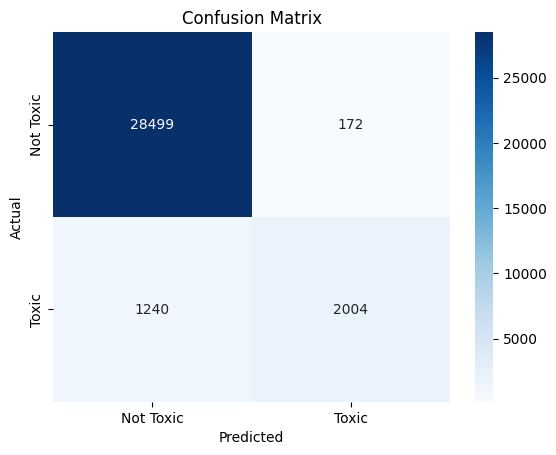

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Toxic', 'Toxic'], yticklabels=['Not Toxic', 'Toxic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# تدريب النموذج مع توازن الفئات
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# التوقع
y_pred = model.predict(X_test_tfidf)

# التقييم
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.94      0.96     28671
           1       0.60      0.85      0.71      3244

    accuracy                           0.93     31915
   macro avg       0.79      0.89      0.83     31915
weighted avg       0.94      0.93      0.93     31915



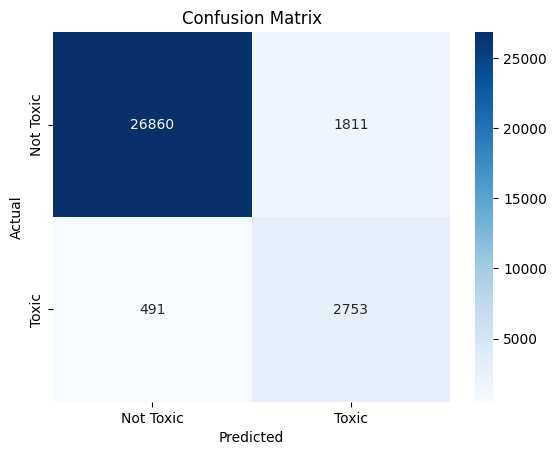

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Toxic', 'Toxic'],
            yticklabels=['Not Toxic', 'Toxic'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [49]:
pip install transformers datasets torch scikit-learn


In [50]:
import pandas as pd

# تحميل البيانات
df = pd.read_csv("train.csv")
df = df[['comment_text', 'toxic']].rename(columns={"toxic": "label"})
df = df.dropna()
df['label'] = df['label'].astype(int)

df.head()


,comment_text,label
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [51]:
from datasets import Dataset

dataset = Dataset.from_pandas(df)


In [52]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['comment_text'], truncation=True, padding='max_length', max_length=128)

dataset = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

In [53]:
dataset = dataset.train_test_split(test_size=0.2)
train_dataset = dataset['train']
test_dataset = dataset['test']


In [54]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
!pip install -U transformers

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    # لازم يكون مع الإصدار الحديث
)



In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()
trainer.evaluate()


In [ ]:
from sklearn.metrics import classification_report

# توقع على بيانات التست
predictions = trainer.predict(test_dataset)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

print(classification_report(y_true, y_pred))
TrainingArguments(
    output_dir="./results",
    run_name="bert-toxic-classification-run1",  # اسم التجربة

)


Step,Training Loss
